In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from fullfrlm import flow_refueling_location_model, random_vessel_generator, flow_computation
from fullfrlm_extra_nodes import flow_refueling_location_model_extra_nodes
from fullfrlm import first_stage_frlm
from fullfrlm import second_stage_frlm
from fullfrlm_extra_nodes import first_stage_frlm_extra_nodes, flow_refueling_location_model_extra_nodes
from fullfrlm_extra_nodes import second_stage_frlm_extra_nodes
import geopy.distance

In [3]:
## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()


#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [4]:
#max nodes in route
max_nodes_in_route = 3
load=1
df_random = random_vessel_generator(df_ivs, load)
flows = flow_computation(df_random)

In [5]:
comp_dict = {'r': [], 'total_stations': [], 'fraction_supported_without': [], 'fraction_supported_with': []}
for r in [50000, 100000, 150000]:
    for total_stations in [10, 50, 100]:
        print(total_stations)
        total_flow0, supported_fraction0, optimal_facilities0 = flow_refueling_location_model(load, r, total_stations, 5, 5, flows)
        total_flow1, supported_fraction1, optimal_facilities1 = flow_refueling_location_model_extra_nodes(load, r, total_stations, 5, 5, flows)
        comp_dict['r'].append(r)
        comp_dict['total_stations'].append(total_stations)
        comp_dict['fraction_supported_without'].append(supported_fraction0)
        comp_dict['fraction_supported_with'].append(supported_fraction1)

10
Optimal
50
Optimal
100
Optimal
10
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Fabia\AppData\Local\Temp\ipykernel_22972\919490348.py", line 6, in <cell line: 2>
    total_flow1, supported_fraction1, optimal_facilities1 = flow_refueling_location_model_extra_nodes(load, r, total_stations, 5, 5, flows)
  File "C:\Users\Fabia\Documents\GitHub\Thesis\ema_workbench\fullfrlm_extra_nodes.py", line 581, in flow_refueling_location_model_extra_nodes
    first_stage_frlm_extra_nodes(r, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h,
  File "C:\Users\Fabia\Documents\GitHub\Thesis\ema_workbench\fullfrlm_extra_nodes.py", line -1, in first_stage_frlm_extra_nodes
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\IPy

In [6]:
comp_dict

{'r': [50000, 50000, 50000],
 'total_stations': [10, 50, 100],
 'fraction_supported_without': [0.0339523458059395,
  0.11330601731697133,
  0.15167378163395964],
 'fraction_supported_with': [0.0339523458059395,
  0.11330601732532661,
  0.18308195733208707]}

In [6]:
df_b, df_g, df_eq_fq, additional_combinations, feasible_combinations = first_stage_frlm_extra_nodes(200000, G, flows,
                                                                                                    paths, path_lengths,
                                                                                                    df_h)

In [5]:
additional_harbour_nodes = []
additional_combinations1 = {i: additional_combinations[i] for i in additional_combinations.keys() if
                            not feasible_combinations[i]}
additional_combinations2 = {i: [] for i in additional_combinations1.keys()}
for i in additional_combinations1.keys():
    if len(additional_combinations1.keys()) > 1:
        for j in additional_combinations1[i]:
            if len(j) <= max_nodes_in_route:
                additional_combinations2[i].append(j)

for i in list(additional_combinations2.values()):
    for j in i:
        for k in j:
            additional_harbour_nodes.append(k)

additional_harbour_nodes = list(set(additional_harbour_nodes))
additional_harbour_nodes = list(
    set(additional_harbour_nodes) - set(harbour_nodes) - {'8861819', '8862449', '8864829', '8860852', '8860640', '8864054', '8861649'})
len(additional_harbour_nodes)

21

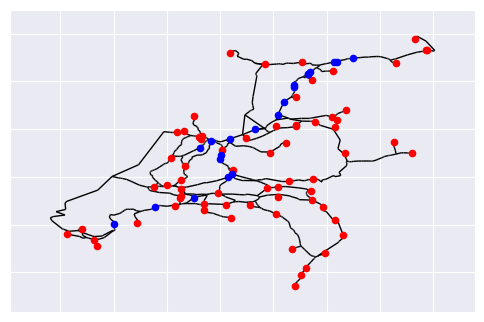

In [6]:
#plot additional nodes
plt.subplots(dpi=100)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_color='red', node_size=20)
nx.draw_networkx_nodes(G, pos_dict, additional_harbour_nodes, node_color='blue', node_size=20)

In [17]:
df_nodes.loc[df_nodes.index=='B16010_B']

,n,X,Y,geometry,Wkt,degree
B16010_B,B16010_B,6.097118,53.207317,"{'type': 'Point', 'coordinates': (6.0971176560...",POINT (6.0971176560896696 53.2073172403509034),2


In [28]:
# create an additional column to put corresponding harbour node in
filtered_add_h = []
# loop over all harbour entries
for i in additional_harbour_nodes:
    x = df_nodes.X[i]
    y = df_nodes.Y[i]
    dev = 0.08
    #find nodes within deviation
    #select nodes near
    selection = df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))]

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found
    while len(selection) == 0:
        dev+=0.1
        selection = list(df_nodes.loc[(df_nodes.X.between(x-dev, x+dev)) & (df_nodes.Y.between(y-dev, y+dev))].index)

    # if any of the nodes nearby is already selected, pick this one
    already_found_near = list(set(list(selection.index))&set(filtered_add_h))
    if len(already_found_near)>0:
        selection = df_nodes.loc[df_nodes.n.isin(already_found_near)]
        selection['dist'] = 0
        for node in selection.index:
            selection.dist[node] = geopy.distance.geodesic((x,y),(selection.X[node],selection.Y[node]))
        pick = selection.loc[selection.dist == selection.dist.min()].index[0]

        if df_nodes[df_nodes.index == pick].degree[0] > df_nodes[df_nodes.index == i].degree[0]:
            filtered_add_h.append(pick)
        else:
            filtered_add_h.remove(pick)
            filtered_add_h.append(i)
    else:
        # else we just add the node itself
        filtered_add_h.append(i)

C:\Users\Fabia\AppData\Local\Temp\ipykernel_10220\1392404090.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['dist'] = 0
C:\Users\Fabia\AppData\Local\Temp\ipykernel_10220\1392404090.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection.dist[node] = geopy.distance.geodesic((x,y),(selection.X[node],selection.Y[node]))
C:\Users\Fabia\AppData\Local\Temp\ipykernel_10220\1392404090.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [29]:
len(list(set(filtered_add_h)))

15

In [30]:

#reset df nodes each time
df_nodes_a = df_nodes.loc[df_nodes.n.isin(additional_harbour_nodes)]
#define Kmeans with cluster size based on loop
km = KMeans(n_clusters=15, init='random', n_init=100, max_iter=300,
            tol=1e-04, random_state=0)

# print('avg group size', i, 'results in', round(len(G.nodes)/i), 'clusters')

#establish input for kmeans
X = df_nodes_a.X.to_numpy()
Y = df_nodes_a.Y.to_numpy()
arr = np.vstack((X, Y)).T

y_km = km.fit_predict(arr)
df_nodes_a['cluster'] = y_km

df_ch = pd.DataFrame(km.cluster_centers_)


C:\Users\Fabia\AppData\Local\Temp\ipykernel_10220\2365133108.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodes_a['cluster'] = y_km


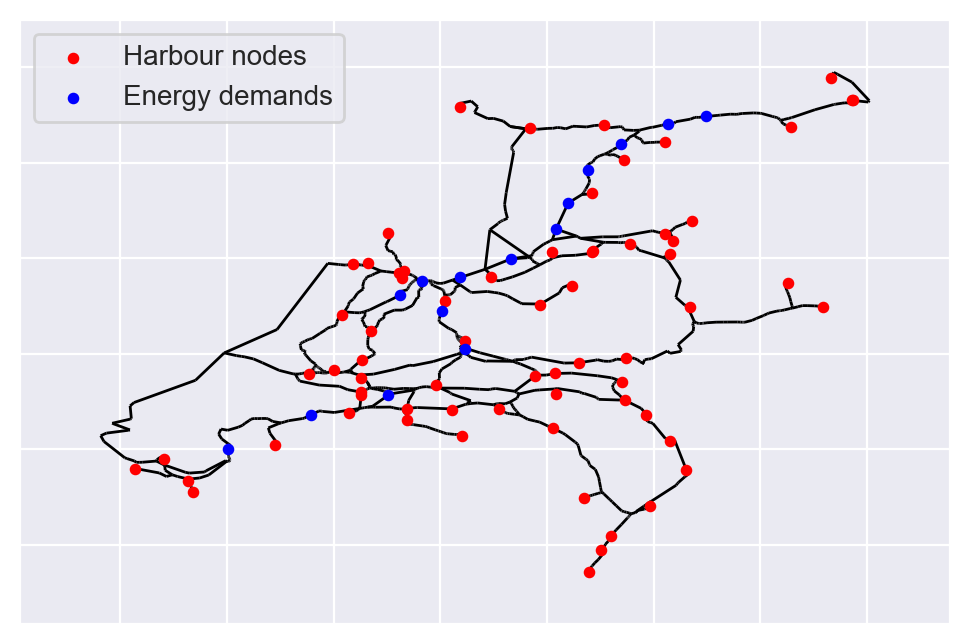

In [31]:
berths = df_nodes.loc[df_nodes.n.str.contains('Berth')]

plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_color='red', node_size=10, label='Harbour nodes')
nx.draw_networkx_nodes(G, pos_dict, filtered_add_h, node_color='blue', node_size=10, label="Energy demands")
# nx.draw_networkx_nodes(G, pos_dict, additional_harbour_nodes, node_color='blue', node_size=10, label="Energy demands")
# plt.scatter(df_ch[0], df_ch[1], color='green', label = 'Clustered energy demands')
# plt.scatter(berths.X, berths.Y, color='green', label='Berths', s=10)
plt.legend()
plt.show()